In [1]:
%matplotlib inline
import networkx as nx
import cluster_query_tool
lfr = nx.community.community_generators.LFR_benchmark_graph
from subprocess import check_output
import networkx as nx
from collections import defaultdict
import numpy as np
from collections import defaultdict
from cluster_query_tool.louvain_consensus import mu_ivector
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, precision_recall_curve, average_precision_score
import os
import seaborn as sns
import json
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [2]:

graph = nx.read_edgelist('../data/arabidopsis_ppi/arabidopsis_ppi.edgelist')

graph = [graph.subgraph(c).copy() for c in nx.connected_components(graph)][0]

graph.name = "arabidopsis_ppi"

print(graph.number_of_nodes(), graph.number_of_edges())

with open('../data/arabidopsis_ppi/arabidopsis_ppi_go.json') as dtfile:
    in_comms = json.load(dtfile)


# Get only the communities we want
nodes = graph.nodes()
comms = dict()
for k, values in in_comms.items():
    in_network = [x for x in values if x in nodes]
    
    if len(in_network) >= 5 and len(in_network) <= 50:
        comms[k] = in_network

4519 11096


In [3]:
# Generate an index
from cluster_query_tool import indexer

print(graph.name, len(comms))
index = indexer.get_index(graph)
print(graph.number_of_nodes(), graph.number_of_edges(), "{:.3f}".format(nx.density(graph)))
print('index of ', len(index), 'paritions')

arabidopsis_ppi 810
4519 11096 0.001
index of  2000 paritions


In [4]:
from scipy.special import binom
import itertools

def unique_sampler(node_set, sample_size, max_samples=120):
    sample_sets = set()
    
    # maximum number of samples
    sspace = binom(len(node_set), sample_size)
    if sspace > max_samples:
        
        if sspace > max_samples * 2:
            # problem with this loop is when max_samples is close to n choose k
            while len(sample_sets) < max_samples:
                samp = tuple(sorted(np.random.choice(node_set, sample_size, replace=False)))
                sample_sets.add(samp)
        else:
            # Generate max_samples, unique random numbers sampling without replacement from possible combinations
            # Faster than above loop in case where n choose k is close to max_samples
            sp = np.random.choice(range(int(binom(len(node_set), sample_size))), max_samples, replace=False)
            poss = list(itertools.combinations(node_set, sample_size))
            for s in  sp:
                sample_sets.add(poss[s])
            
    else:
        sample_sets = set(itertools.combinations(node_set, sample_size))
    
    return sample_sets

0 regulation of seed germination 16
1 photosystem II oxygen evolving complex 6


/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice.
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must have same first dimension, but have shapes (101,) and (1,)

<Figure size 432x288 with 0 Axes>

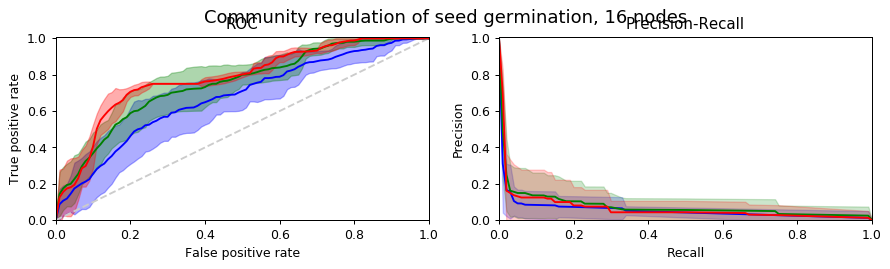

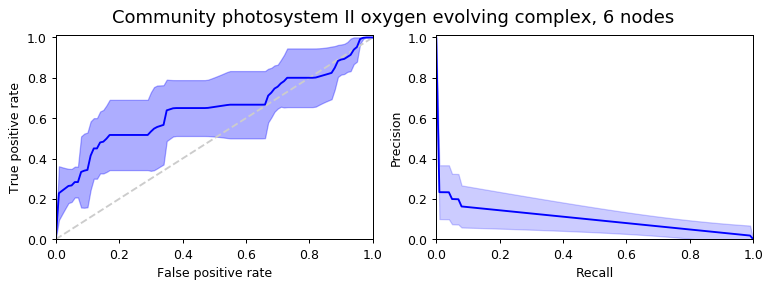

In [10]:
from scipy import interp

seed_sizes = [3, 7, 13]
samples = 10

color = {
    3: "b",
    7: "g",
    13: "r",
}


auc_scores = dict()
app_scores = dict()

for c, k in enumerate(list(comms.keys())[:30]):
    
    print(c, k, len(comms[k]))
    plt.figure(c)
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_dpi(90)
    fig.set_size_inches(10, 3)
    fig.suptitle("Community {}, {} nodes".format(k, len(comms[k])), fontsize="x-large")
    
    if c not in auc_scores:
        auc_scores[c] = dict()
        app_scores[c] = dict()
    
   
    axes[0].set_xlabel("False positive rate")
    axes[0].set_ylabel("True positive rate")

    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.01])
    
    
    axes[1].set_ylabel("Precision")
    axes[1].set_xlabel("Recall")
    
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.01])
    
    axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
    
    
    for seed_size in seed_sizes:
        s = seed_size
        if seed_size not in auc_scores[c]:
            auc_scores[c][s] = []
            app_scores[c][s] = []
        
            tprs = []
            base_fpr = np.linspace(0, 1, 101)

            presc = []
            base_pr = np.linspace(0, 1, 101)

            sampled_sets = unique_sampler(comms[k], seed_size, max_samples=samples)
            vecs = Parallel(n_jobs=24) ( delayed(mu_ivector)(graph, index, cs) for cs in sampled_sets)

            for vec, key in vecs:
                inc = lambda x: 1 if x in comms[k] else 0
                y_true = [inc(x) for x in graph.nodes()]
                y_score = [vec[key[x]] for x in graph.nodes()]


                auc_scores[c][s].append(roc_auc_score(y_true, y_score))
                app_scores[c][s].append(average_precision_score(y_true, y_score))

                fpr, tpr, _ = roc_curve(y_true, y_score)

                tpr = interp(base_fpr, fpr, tpr)
                tpr[0] = 0.0
                tprs.append(tpr) 

                precision, recall, _ = precision_recall_curve(y_true, y_score)

                tpr = interp(base_pr, precision, recall)
                tpr[0] = 1.0
                presc.append(tpr) 

            tprs = np.array(tprs)
            mean_tprs = tprs.mean(axis=0)
            std = tprs.std(axis=0)

            tprs_upper = np.minimum(mean_tprs + std, 1)
            tprs_lower = mean_tprs - std

            axes[0].plot(base_fpr, mean_tprs, color=color[seed_size])
            axes[0].fill_between(base_fpr, tprs_lower, tprs_upper,  color=color[seed_size], alpha=0.32)


            tprs = np.array(presc)
            mean_tprs = tprs.mean(axis=0)
            std = tprs.std(axis=0)

            tprs_upper = np.minimum(mean_tprs + std, 1)
            tprs_lower = mean_tprs - std

            axes[1].plot(base_pr, mean_tprs, color=color[seed_size])
            axes[1].fill_between(base_fpr, tprs_lower, tprs_upper, color=color[seed_size], alpha=0.2)
    
    
    axes[0].set_title('ROC')#, mean AUC={:.2f}'.format(np.mean(auc_scores[c])))
    
    axes[1].set_title('Precision-Recall')# mean AP={:.2f}'.format(np.mean(app_scores[c])))
    
    plt.tight_layout()
    fig.savefig('figs/arabidopsis_ppi_roc_prc_{}.eps'.format(k))
    fig.savefig('figs/arabidopsis_ppi_roc_prc_{}.svg'.format(k))
    fig.savefig('figs/arabidopsis_ppi_roc_prc_{}.png'.format(k))
    

In [11]:
from joblib import Parallel, delayed
from sklearn.metrics import roc_auc_score, roc_curve, auc

def calc(community, samp):
    vec, key = mu_ivector(graph, index, samp)
    inc = lambda x: 1 if x in community else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    return roc_auc_score(y_true, y_score)

def get_roc_auc(graph, community, seed_size, samples=120):
    sample_sets = unique_sampler(community, seed_size, max_samples=samples)

    res = Parallel(n_jobs=24)(delayed(calc)(community, samp) for samp in sample_sets)
    return np.mean(res), np.std(res)

In [ ]:
seed_sizes = [3, 7, 13]
n_samples =  120

aucs = dict()
stds = dict()

for c in comms:
    aucs[c] = dict()
    stds[c] = dict()
    for size in seed_sizes:
        aucs[c][size] = 0.0
        stds[c][size] = 0.0
        if size < len(comms[c]):
            m, sd = get_roc_auc(graph, comms[c], size, samples=n_samples)
            aucs[c][size] = m
            stds[c][size] = sd


In [ ]:
width=0.25
max_c_size = 30

sorted_comms = sorted([c for c in comms if len(comms[c]) < max_c_size], key=lambda x: len(comms[x]))
ind = np.arange(len(sorted_comms))
fig, ax = plt.subplots()



for i, s in enumerate(seed_sizes):
    ind_x = ind  + (i* width)
    means = [aucs[c][s] for c in sorted_comms]
    err = [stds[c][s] for c in sorted_comms]
    rects = ax.bar(ind_x, means, width, yerr=err, label='{} seed nodes'.format(s))

    
fig.set_dpi(80)
fig.set_size_inches(10, 5)
    
ticks = ax.set_xticklabels(["".format(i) for i,c in enumerate(sorted_comms)])

ax.set_ylabel("Mean AUC score")
ax.set_xlabel("Community")
ax.set_xticks(ind + 0.3)
ax.set_ylim((0.4, 1.05))
ax.axhline(0.5, linestyle='--', color='#000000', linewidth=0.5)
ax.tick_params(labelsize=6)
ax.legend()

fig.savefig('figs/arabidopsis_ppi_roc_scores.svg')
fig.savefig('figs/arabidopsis_ppi_roc_scores.eps')
fig.savefig('figs/arabidopsis_ppi_roc_scores.png')

In [14]:
print(graph.number_of_nodes(), graph.number_of_edges(), len(comms), len([x for x in comms if len(comms[x]) >=3 ]))

4519 11096 810 810


In [15]:
len([x for x in comms if len(comms[x]) >=50 ])/(len(comms))

0.0012345679012345679

In [16]:
node_comms = defaultdict(list)

for c, com in comms.items():
    for node in com:
        node_comms[node] += com

for node in node_comms:
    node_comms[node] = list(set(node_comms[node]))
    
    

In [17]:
# Calculate the relatedness score for individual nodes in our dataset
node_wise_mu_i = dict()

def mui_n(node):
    vec, key = mu_ivector(graph, index, [node])
    return node, vec, key

vecs = Parallel(n_jobs=24) ( delayed(mui_n)(node) for node in node_comms)

for n, v, k in vecs:
    node_wise_mu_i[n] = (v,k)
    

In [18]:
# Binary classification for each node

def roc_score_node(n, vec, key):
    inc = lambda x: 1 if x in node_comms[n] else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    score = roc_auc_score(y_true, y_score)
    return score


nwise_roc_scores = Parallel(n_jobs=24) ( delayed(roc_score_node)(node, *node_wise_mu_i[node]) for node in node_comms if len(node_comms[node]) > 1) 

print(np.mean(nwise_roc_scores))

0.5974674191832358


In [19]:
# Binary classification for each node

def roc_score_node(n, vec, key):
    inc = lambda x: 1 if x in node_comms[n] else 0
    y_true = [inc(x) for x in graph.nodes()]
    y_score = [vec[key[x]] for x in graph.nodes()]
    curve = roc_curve(y_true, y_score)
    return curve


nwise_roc_curves = Parallel(n_jobs=24) ( delayed(roc_score_node)(node, *node_wise_mu_i[node]) for node in node_comms if len(node_comms[node]) > 1) 



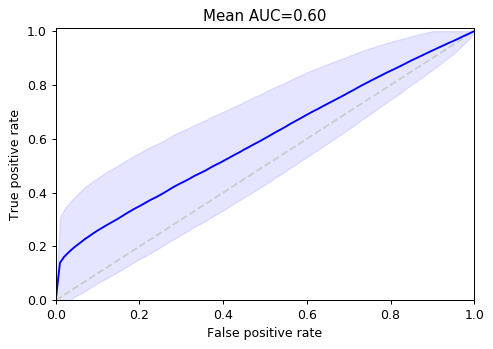

In [20]:
fig, ax = plt.subplots()
fig.set_dpi(90)


ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.01])

tprs = []
base_fpr = np.linspace(0, 1, 101)

for fpr,tpr,_ in nwise_roc_curves:
    tpr = interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--', color="#cccccc")
ax.plot(base_fpr, mean_tprs, color="b")
ax.fill_between(base_fpr, tprs_lower, tprs_upper, color="b", alpha=0.1)
ax.set_title("Mean AUC={:.2f}".format(np.mean(nwise_roc_scores)))

fig.savefig("figs/arabidopsis_ppi_nodewise_roc.eps")
fig.savefig("figs/arabidopsis_ppi_nodewise_roc.svg")
fig.savefig("figs/arabidopsis_ppi_nodewise_roc.png")


In [ ]:
print(len(node_comms))

/home/mbzjpg/repos/cluster_query_tool/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


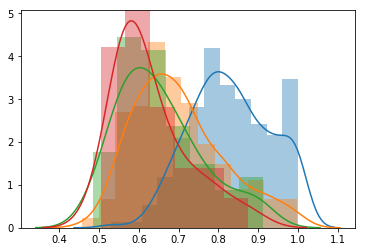

In [ ]:
comm_avg = dict()
comm_mu_dist = dict()


for k, community in comms.items():
    vec, key = mu_ivector(graph, index, community)
    dist = [vec[key[i]] for i in community]
    comm_mu_dist[k] = dist
    comm_avg[k] = np.mean(dist)

In [ ]:
n_samples = 100
rand_dist = dict()
for s in range(1, 101):
    np.random.choice(nodes, n_samples, )
    rand_dist[s] = 
    